In [64]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

In [102]:
df = pd.read_csv('prediction_result.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
x=df['date']
originaly=df['origin']
predictiony0=df['close(t)']
predictiony1=df['close(t+1)']
df=df.set_index('date')
df

,origin,close(t),close(t+1)
date,,,
2019-07-03,303.11823,303.60574,296.81590
2019-07-04,284.41977,309.02450,303.19293
2019-07-05,287.97790,304.57602,299.69812
2019-07-06,287.50458,303.37424,295.83423
2019-07-07,305.76273,296.10210,288.60770
...,...,...,...
2024-02-24,2991.81130,3081.00150,2959.99580
2024-02-25,3111.15720,3106.41300,2977.27150
2024-02-26,3179.37740,3153.22660,3036.63100


# 计算信号 (只计算测试集）
资产分2份，2天为一周期，每天都判断，如2天后的收盘价大于当前价则买一份，买信号发出2天后必卖一份，策略偏保守，最大回撤小，收益小

In [103]:
dataset = {'date':x,
           'close(t-1)':originaly,
       'close(t)':predictiony0,
       'close(t+1)':predictiony1}
df = DataFrame(dataset)
# df.set_index(['date'], inplace = True, drop=True) 
df['close(t+1)-close(t-1)'] = df['close(t+1)'] - df['close(t-1)']
df['isbuy'] = df['close(t+1)-close(t-1)'] > 0
df['issell'] = df['isbuy'].shift(2) #n_out=2
df['issell'].fillna(value= False, inplace=True)
df

,date,close(t-1),close(t),close(t+1),close(t+1)-close(t-1),isbuy,issell
0,2019-07-03,303.11823,303.60574,296.81590,-6.30233,False,False
1,2019-07-04,284.41977,309.02450,303.19293,18.77316,True,False
2,2019-07-05,287.97790,304.57602,299.69812,11.72022,True,False
3,2019-07-06,287.50458,303.37424,295.83423,8.32965,True,True
4,2019-07-07,305.76273,296.10210,288.60770,-17.15503,False,True
...,...,...,...,...,...,...,...
1697,2024-02-24,2991.81130,3081.00150,2959.99580,-31.81550,False,True
1698,2024-02-25,3111.15720,3106.41300,2977.27150,-133.88570,False,True
1699,2024-02-26,3179.37740,3153.22660,3036.63100,-142.74640,False,False
1700,2024-02-27,3243.10800,3233.77050,3113.91280,-129.19520,False,False


# 计算仓位¶

In [104]:
initlocation = 0 #初始仓位为0
initUS = 2 #初始美元现金为2
maxlocation = 2 #满仓为2
def function(isbuy, issell):
    if issell and (not isbuy): return -1
    if isbuy and issell: return 0
    if (not isbuy) and (not issell): return 0
    if isbuy and (not issell): return 1

df['location action'] = df.apply(lambda x: function(x.isbuy, x.issell), axis = 1)
df['location status'] = df['location action'].expanding().sum()
df['location status'] = df['location status'] / df['location status'].max()
df

,date,close(t-1),close(t),close(t+1),close(t+1)-close(t-1),isbuy,issell,location action,location status
0,2019-07-03,303.11823,303.60574,296.81590,-6.30233,False,False,0,0.0
1,2019-07-04,284.41977,309.02450,303.19293,18.77316,True,False,1,0.5
2,2019-07-05,287.97790,304.57602,299.69812,11.72022,True,False,1,1.0
3,2019-07-06,287.50458,303.37424,295.83423,8.32965,True,True,0,1.0
4,2019-07-07,305.76273,296.10210,288.60770,-17.15503,False,True,-1,0.5
...,...,...,...,...,...,...,...,...,...
1697,2024-02-24,2991.81130,3081.00150,2959.99580,-31.81550,False,True,-1,0.5
1698,2024-02-25,3111.15720,3106.41300,2977.27150,-133.88570,False,True,-1,0.0
1699,2024-02-26,3179.37740,3153.22660,3036.63100,-142.74640,False,False,0,0.0
1700,2024-02-27,3243.10800,3233.77050,3113.91280,-129.19520,False,False,0,0.0


# 计算资金曲线¶

In [105]:
df['cycle growth rate'] = df['close(t-1)'].diff()
df['cycle growth rate'] = df['cycle growth rate'].shift(-1)
df['cycle growth rate'].fillna(value=0, inplace=True)
df['cycle growth rate'] = df['cycle growth rate'] /  df['close(t-1)'] 
df['Asset cycle growth rate'] = df['location status'] * df['cycle growth rate']
df['cycle growth rate'] = df['cycle growth rate'].shift(1)
df['cycle growth rate'].fillna(value=0, inplace=True)
df['Asset cycle growth rate'] = df['Asset cycle growth rate'].shift(1)
df['Asset cycle growth rate'].fillna(value=0, inplace=True)
df['Asset cycle growth rate'] = df['Asset cycle growth rate'] + 1
df['Asset growth rate'] = df['Asset cycle growth rate'].cumprod()
df['ETH growth rate'] = (df['cycle growth rate']+1).cumprod()
df

,date,close(t-1),close(t),close(t+1),close(t+1)-close(t-1),isbuy,issell,location action,location status,cycle growth rate,Asset cycle growth rate,Asset growth rate,ETH growth rate
0,2019-07-03,303.11823,303.60574,296.81590,-6.30233,False,False,0,0.0,0.000000,1.000000,1.000000,1.000000
1,2019-07-04,284.41977,309.02450,303.19293,18.77316,True,False,1,0.5,-0.061687,1.000000,1.000000,0.938313
2,2019-07-05,287.97790,304.57602,299.69812,11.72022,True,False,1,1.0,0.012510,1.006255,1.006255,0.950051
3,2019-07-06,287.50458,303.37424,295.83423,8.32965,True,True,0,1.0,-0.001644,0.998356,1.004601,0.948490
4,2019-07-07,305.76273,296.10210,288.60770,-17.15503,False,True,-1,0.5,0.063506,1.063506,1.068399,1.008724
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,2024-02-24,2991.81130,3081.00150,2959.99580,-31.81550,False,True,-1,0.5,0.023896,1.023896,3.853106,9.870113
1698,2024-02-25,3111.15720,3106.41300,2977.27150,-133.88570,False,True,-1,0.0,0.039891,1.019945,3.929958,10.263841
1699,2024-02-26,3179.37740,3153.22660,3036.63100,-142.74640,False,False,0,0.0,0.021928,1.000000,3.929958,10.488902
1700,2024-02-27,3243.10800,3233.77050,3113.91280,-129.19520,False,False,0,0.0,0.020045,1.000000,3.929958,10.699152


In [106]:
df['Asset net value'] = df['Asset growth rate'] * df['close(t-1)'][0]
df

,date,close(t-1),close(t),close(t+1),close(t+1)-close(t-1),isbuy,issell,location action,location status,cycle growth rate,Asset cycle growth rate,Asset growth rate,ETH growth rate,Asset net value
0,2019-07-03,303.11823,303.60574,296.81590,-6.30233,False,False,0,0.0,0.000000,1.000000,1.000000,1.000000,303.118230
1,2019-07-04,284.41977,309.02450,303.19293,18.77316,True,False,1,0.5,-0.061687,1.000000,1.000000,0.938313,303.118230
2,2019-07-05,287.97790,304.57602,299.69812,11.72022,True,False,1,1.0,0.012510,1.006255,1.006255,0.950051,305.014255
3,2019-07-06,287.50458,303.37424,295.83423,8.32965,True,True,0,1.0,-0.001644,0.998356,1.004601,0.948490,304.512934
4,2019-07-07,305.76273,296.10210,288.60770,-17.15503,False,True,-1,0.5,0.063506,1.063506,1.068399,1.008724,323.851210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,2024-02-24,2991.81130,3081.00150,2959.99580,-31.81550,False,True,-1,0.5,0.023896,1.023896,3.853106,9.870113,1167.946716
1698,2024-02-25,3111.15720,3106.41300,2977.27150,-133.88570,False,True,-1,0.0,0.039891,1.019945,3.929958,10.263841,1191.241910
1699,2024-02-26,3179.37740,3153.22660,3036.63100,-142.74640,False,False,0,0.0,0.021928,1.000000,3.929958,10.488902,1191.241910
1700,2024-02-27,3243.10800,3233.77050,3113.91280,-129.19520,False,False,0,0.0,0.020045,1.000000,3.929958,10.699152,1191.241910


# 绘制资金曲线¶

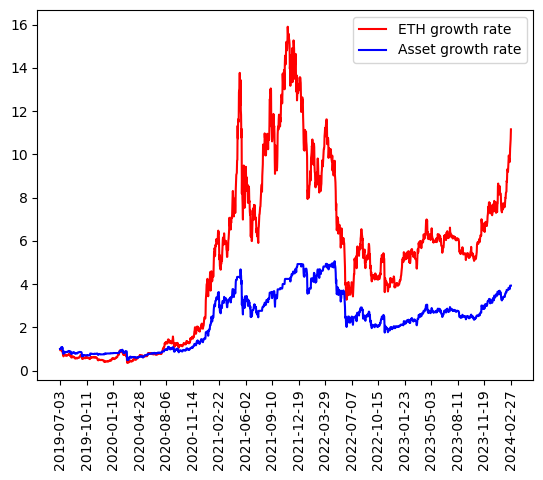

date
2024-02-24     9.870113
2024-02-25    10.263841
2024-02-26    10.488902
2024-02-27    10.699152
2024-02-28    11.154722
Name: ETH growth rate, dtype: float64
date
2024-02-24    3.853106
2024-02-25    3.929958
2024-02-26    3.929958
2024-02-27    3.929958
2024-02-28    3.929958
Name: Asset growth rate, dtype: float64


In [115]:
%matplotlib inline 
plt.figure()
plt.plot(df.index,df['ETH growth rate'].values.reshape(-1), 'r', label='ETH growth rate')
plt.plot(df.index,df['Asset growth rate'].values.reshape(-1), 'b', label='Asset growth rate')
plt.xticks(df.index[::100],  rotation='vertical')

plt.legend()
plt.show()
print(df['ETH growth rate'].tail())
print(df['Asset growth rate'].tail())

In [143]:
def asset_performance_management(performance_return):
    sharpe = (performance_return['Asset growth rate'].mean() / performance_return.std())['Asset growth rate']
    withdraw = 0
    max_withdraw = 0
    DAYS = len(performance_return['date'])
    for i in range(DAYS):
        for j in range(i, DAYS):
            if performance_return['Asset net value'][j] < performance_return['Asset net value'][i]:
                withdraw = (performance_return['Asset net value'][i] - performance_return['Asset net value'][j]) / performance_return['Asset net value'][i]
            if withdraw > max_withdraw:
                max_withdraw = withdraw
    hpr = (performance_return['Asset net value'][DAYS - 1] - performance_return['Asset net value'][0]) / performance_return['Asset net value'][0]
    annual_vol = np.std(performance_return['Asset growth rate'])*np.sqrt(252)
    calmar_ratio = (hpr * np.sqrt(252) * 100 / (DAYS - 1))/max_withdraw
    print('Holding Period Return: %.2f%%' % (hpr * 100))
    print('Annual Return: %.2f%%' % (hpr * np.sqrt(252) * 100 / (DAYS - 1)))
    print('Annual Volatility: %.2f%%' % annual_vol)
    print('Sharpe: %.2f' % sharpe)
    print('Maximum Drawdown: %.2f' % max_withdraw)
    print('Calmar Ratio: %.2f' % calmar_ratio)

In [139]:
def ETH_performance_management(performance_return):
    sharpe = (performance_return['ETH growth rate'].mean() / performance_return.std())['ETH growth rate']
    withdraw = 0
    max_withdraw = 0
    DAYS = len(performance_return['date'])
    for i in range(DAYS):
        for j in range(i, DAYS):
            if performance_return['close(t-1)'][j] < performance_return['close(t-1)'][i]:
                withdraw = (performance_return['Asset net value'][i] - performance_return['close(t-1)'][j]) / performance_return['Asset net value'][i]
            if withdraw > max_withdraw:
                max_withdraw = withdraw
    hpr = (performance_return['close(t-1)'][DAYS - 1] - performance_return['close(t-1)'][0]) / performance_return['Asset net value'][0]
    annual_vol = np.std(performance_return['ETH growth rate'])*np.sqrt(252)
    calmar_ratio = (hpr * np.sqrt(252) * 100 / (DAYS - 1))/max_withdraw
    print('Holding Period Return: %.2f%%' % (hpr * 100))
    print('Annual Return: %.2f%%' % (hpr * np.sqrt(252)* 100 / (DAYS - 1)))
    print('Annual Volatility: %.2f%%' % annual_vol)
    print('Sharpe: %.2f' % sharpe)
    print('Maximum Drawdown: %.2f' % max_withdraw)
    print('Calmar Ratio: %.2f' % calmar_ratio)

In [144]:
# df=df.reset_index()
asset_performance_management(df)

/var/folders/lp/2qf3969x3rz9wd_rlf3gnzr00000gn/T/ipykernel_6546/2435314913.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sharpe = (performance_return['Asset growth rate'].mean() / performance_return.std())['Asset growth rate']


Holding Period Return: 293.00%
Annual Return: 2.73%
Annual Volatility: 20.09%
Sharpe: 1.89
Maximum Drawdown: 0.65
Calmar Ratio: 4.19


In [140]:
ETH_performance_management(df)

/var/folders/lp/2qf3969x3rz9wd_rlf3gnzr00000gn/T/ipykernel_6546/1474499849.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sharpe = (performance_return['ETH growth rate'].mean() / performance_return.std())['ETH growth rate']


Holding Period Return: 1015.47%
Annual Return: 9.48%
Annual Volatility: 60.01%
Sharpe: 1.38
Maximum Drawdown: 0.66
Calmar Ratio: 14.30
